# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens. min (2, 30, 5)

In [40]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens
from lib.create_dataset import create_dataset

In [41]:
def make_ready(filer):
    stocks = []
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = rens().clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_15_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma15_derivert'] = [stock.open_15_sma[i] / stock.open_15_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_15_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        #break # må tas bort ettervært
        stocks.append(stock)
    
    return stocks

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [42]:
filer = list(map(add_data, os.listdir('data/')))[26:32] # test 54:60
data = make_ready(filer)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [66]:
def prepare_data_for_training(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[['macd', 'rsi_20', 'sma8-16', 'trix', 'volume']],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
    
dataxes, datayes = prepare_data_for_training(data)


In [63]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.33, shuffle=True, random_state=42)
X_train.shape

(1257, 30, 5)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [48]:
model = Sequential()

model.add(LSTM(units=256, input_dim=5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 256)         268288    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 796,170
Trainable params: 796,170
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, verbose=1)

Train on 1257 samples, validate on 620 samples
Epoch 1/5
1257/1257 [==============================] - 31s 25ms/sample - loss: 0.3658 - mae: 0.4341 - val_loss: 0.3590 - val_mae: 0.4574
Epoch 2/5
1257/1257 [==============================] - 17s 14ms/sample - loss: 0.3071 - mae: 0.4002 - val_loss: 0.2593 - val_mae: 0.3756
Epoch 3/5
1257/1257 [==============================] - 17s 14ms/sample - loss: 0.2453 - mae: 0.3637 - val_loss: 0.2503 - val_mae: 0.3704
Epoch 4/5
1257/1257 [==============================] - 17s 13ms/sample - loss: 0.2330 - mae: 0.3515 - val_loss: 0.2024 - val_mae: 0.3326
Epoch 5/5
1257/1257 [==============================] - 16s 13ms/sample - loss: 0.1970 - mae: 0.3218 - val_loss: 0.1935 - val_mae: 0.3217


### Plotte validation kurve

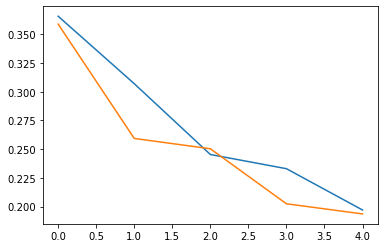

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.xlim(50,100)
#plt.ylim(0.0, 0.025)

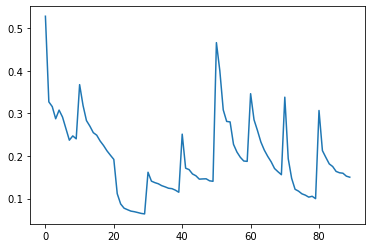

In [265]:
#plt.plot(history.history['loss'])
flatten = [j for sub in all_history for j in sub]
#all_history
#for h in all_history:
plt.plot(flatten)

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [67]:
filer = list(map(add_data, os.listdir('data/')))[50:52] # test 54:60
data_test = make_ready(filer)
dataxes, datayes = prepare_data_for_test(data)

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [71]:
pred = []

for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

C:\Users\Stian\anaconda3\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [74]:
pred.shape

(6,)

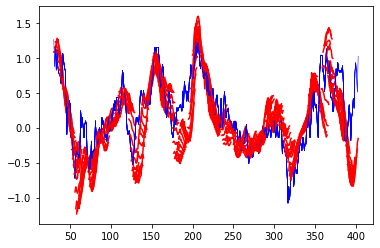

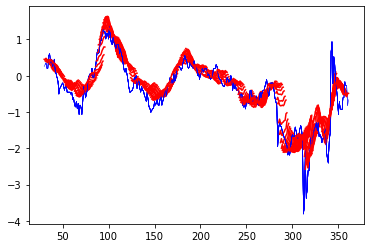

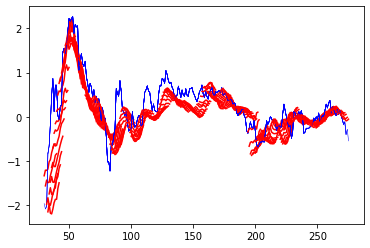

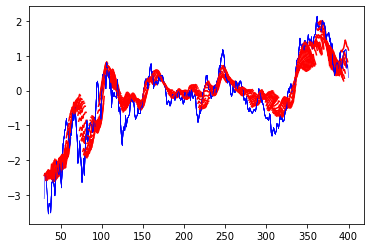

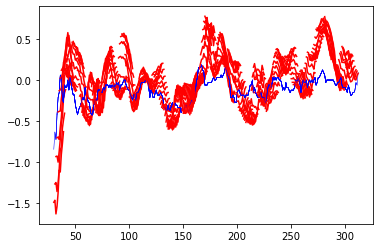

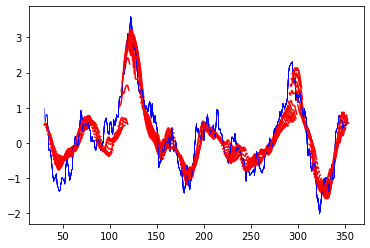

In [84]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

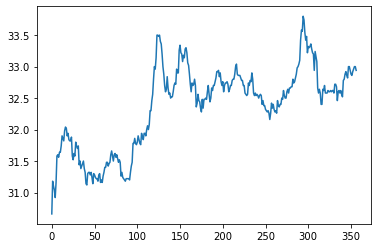

In [39]:
plt.plot(data[0]['open'])

## Save model

In [152]:
# Save model

model.save('models/rnn_model.h5')

In [56]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 0223-158D

 Directory of C:\Users\Stian\Documents\School\99. Div\intradag

19.09.2020  00.30    <DIR>          .
19.09.2020  00.30    <DIR>          ..
16.08.2020  17.38    <DIR>          .idea
01.09.2020  19.48    <DIR>          .ipynb_checkpoints
24.08.2020  21.27    <DIR>          data
26.08.2020  22.16    <DIR>          history
18.09.2020  19.30    <DIR>          images
25.08.2020  13.08    <DIR>          lib
30.08.2020  10.25           514ÿ958 make_model.ipynb
19.09.2020  00.30    <DIR>          models
29.08.2020  11.29               664 README.md
19.09.2020  00.29           132ÿ506 RNN_trial.ipynb
16.08.2020  17.14         3ÿ922ÿ732 smadaytrade.ipynb
01.09.2020  20.07           775ÿ971 use_model.ipynb
17.08.2020  12.53    <DIR>          __pycache__
               5 File(s)      5ÿ346ÿ831 bytes
              10 Dir(s)  75ÿ003ÿ355ÿ136 bytes free
